# Geospatial Data

This notebook demonstrates common workflows to analyze geospatial data such as loading geographic data in Python, geocoding, and doing simple spatial statistics. There are a ton of similarities between GeoPandas and Pandas, in fact GeoPandas can be thought of as an extension of Pandas and shares many of the same functionality. The two driving forces behind all GeoPandas operations are **GeoDataFrames** and **GeoSeries** – extensions of DataFrames and Series in Pandas. The difference is that **GeoDataFrames / GeoSeries** provide geo specific functionality enabling things such as the plotting of geometry, spatial joins, and mapping projections.

In [40]:
import geopandas as gpd
import requests
from sodapy import Socrata
import os
import pandas as pd
from shapely import wkt
from shapely.geometry import shape 
from shapely.ops import nearest_points

# Loading spatial data

For this example I will load a GeoJSON file of US zip codes from the class Google drive.

In [2]:
path = '/Users/carlo/Downloads/geo_data 2/us_zipcodes.geojson'
gdf = gpd.read_file(path)

In [3]:
print(gdf.shape)
gdf.head()

(33144, 11)


,region_id,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53922,53922,53922,B5,G6350,S,118603010,1919478,43.520930,-88.715147,"POLYGON ((-88.79170 43.53140, -88.79127 43.531..."
1,15027,15027,15027,B5,G6350,S,3728900,473269,40.666338,-80.240179,"POLYGON ((-80.25520 40.67407, -80.25538 40.673..."
2,95605,95605,95605,B5,G6350,S,10099869,434268,38.593521,-121.539867,"POLYGON ((-121.58275 38.57903, -121.58277 38.5..."
3,04468,04468,4468,B5,G6350,S,308900427,7915129,45.024673,-68.734534,"POLYGON ((-68.84231 45.09506, -68.84195 45.093..."
4,37160,37160,37160,B5,G6350,S,594479863,1466926,35.455746,-86.484790,"MULTIPOLYGON (((-86.46235 35.62683, -86.46236 ..."


# Coordinate Reference Systems (CRS)

The Coordinate Reference System (CRS) is an important concept in geospatial data because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth and thus how they should appear when you plot them in a map.


## Setting the CRS

A lot of the time geographic data will already have a CRS assigned, but there are some cases when they don't and to manually assign a CRS:

In [ ]:
gdf.crs = "EPSG:4326"

To view the CRS of a GeoDataFrame

In [4]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Plotting geometries within a GeoDataFrame

To plot a single NYC zipcode in our GeoDataFrame we can filter use the same indexing methods available in Pandas followed by the **.plot()** function.

<AxesSubplot:>

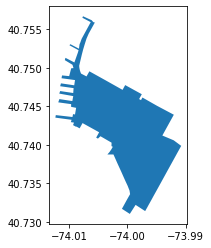

In [5]:
# Plotting the Chelsea, Manhattan zip code (10011)
gdf[gdf['region_id']=='10011'].plot()

# Geocoding Data with the HERE API

# Analyzing Geospatial Data

In [6]:
# first we have to connect to the Socrata API to access NYC data
client = Socrata("data.cityofnewyork.us", os.environ['nyc_soda_cuny_token'])

Next we download the building footprints dataset and the property valuation dataset

In [7]:
results = client.get("yjyb-7w4g", limit=1000000)
bldgs = pd.DataFrame.from_records(results)

In [8]:
print(bldgs.shape)
bldgs.head(1)

(1000000, 15)


,cnstrct_yr,the_geom,bin,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,name
0,2009,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",3394646,2017-08-22T00:00:00.000Z,Constructed,1212853,21.60850812,2100,18,854.66243317866,125.0797955584,3044520815,3044520815,Photogramm,NaN


In [24]:
# results = client.get("yjxr-fw8i", limit=int(10e6))

In [9]:
val = pd.read_csv('data/Property_Valuation_and_Assessment_Data.csv',
                  dtype={'BORO': str, 'BLOCK': str, 'LOT': str})

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
val['bbl'] = val['BORO'] + val['BLOCK'] + val['LOT']
val = val.dropna(subset=['Latitude'])

In [13]:
val.rename(columns={'New Georeferenced Column': 'geom'}, inplace=True)
val['geom'] = val['geom'].apply(wkt.loads)

In [11]:
print(val.shape)
val.head(1)

(9501114, 41)


,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA,New Georeferenced Column,bbl
0,1015571186,1,1557,1186,NaN,THE MARMARA INC.,RH,4,0,0,...,MANHATTAN,40.782799,-73.947678,108.0,5.0,15601.0,1050324.0,Yorkville,POINT (-73.947678 40.782799),115571186


In [25]:
bldgs['the_geom'] = bldgs['the_geom'].apply(shape)

In [26]:
# convert data to GeoDataFrames
bldgs = gpd.GeoDataFrame(bldgs, geometry='the_geom')
val = gpd.GeoDataFrame(val, geometry='geom')
bldgs = bldgs.set_crs(epsg=3857)
val = val.set_crs(epsg=3857)

In [28]:
combined = bldgs.merge(val, left_on='mpluto_bbl',
                       right_on='BBLE')

In [29]:
combined = combined[combined['TAXCLASS'] == '1']

In [30]:
print(combined.shape)
combined.head(1)

(7275632, 56)


,cnstrct_yr,the_geom,bin,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA,geom,bbl
0,2009,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ...",3394646,2017-08-22T00:00:00.000Z,Constructed,1212853,21.60850812,2100,18,854.66243317866,...,BROOKLYN,40.657362,-73.8714,305.0,42.0,1070.0,3394646.0,East New York,POINT (-73.87140 40.65736),34452815


In [32]:
poi = client.get("6td7-3n3g", limit=25500)
poi_df = pd.DataFrame.from_records(poi)

In [33]:
print(poi_df.shape)
poi_df.head(1)

(20402, 16)


,the_geom,segmentid,saftype,complexid,sos,placeid,faci_dom,bin,borough,created,modified,facility_t,source,b7_sc,pri_add,name
0,"{'type': 'Point', 'coordinates': [-73.93149397...",193927,N,401,1,1031153,8,0,1,2018-04-12T00:00:00.000Z,2020-03-12T00:00:00.000Z,6,DCP,11095502,0,HRD RAMP TO GWB OVER HRD SB


In [34]:
poi_df['the_geom'] = poi_df['the_geom'].apply(lambda x: shape(x))

In [35]:
poi_df = gpd.GeoDataFrame(poi_df, geometry='the_geom')
poi_df = poi_df.set_crs(epsg=3857)

In [36]:
places = ['museum', 'theatre', 'theater', 'gallery', 'thtr',
          'art', 'cinema', 'cinemas', 'moma', 'BREUER', 'drawing center']
culture_df = poi_df[(poi_df['facility_t']=='3') & 
                    (poi_df['name'].str.lower().str.contains('|'.join(places)))]

In [41]:
# unary union of the culture_df geomtries 
clt = culture_df.the_geom.unary_union

def near(point, pts):
    # find the nearest poi
    nearest = nearest_points(point, pts)[1]
    return point.distance(nearest)

In [43]:
# combined['distance'] = combined.apply(lambda x: near(x.the_geom.centroid, clt), axis=1)